# Real-Time Bitcoin Data Pipeline: Example Use Case

This notebook demonstrates the complete workflow of a real-time Bitcoin data processing pipeline using utility functions from `bitcoin_utils.py`. It provides visual insights into the price trends and detects anomalies using Airflow-compatible components.

## Objectives
- Fetch live Bitcoin price from the CoinGecko API
- Save raw data with timestamp
- Detect anomalies in hourly and daily price changes
- Archive snapshots of raw data
- Compute moving average and standard deviation
- Upload processed results to AWS S3
- Visualize key insights

### References
- [airflow.API.md](airflow.API.md): API documentation
- [airflow.example.md](airflow.example.md): Full implementation explanation
- [CoinGecko API](https://www.coingecko.com/en/api)

In [18]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Imports and Logging Setup


In [19]:
import os
import logging
import importlib
import matplotlib.pyplot as plt
import pandas as pd

os.makedirs("./data", exist_ok=True)
os.environ["BITCOIN_RAW_PATH"] = "./data/bitcoin_raw.csv"
os.environ["BITCOIN_PROCESSED_PATH"] = "./data/bitcoin_processed.csv"
os.environ["BITCOIN_ARCHIVE_PATH"] = "./data/archive"

import bitcoin_utils
importlib.reload(bitcoin_utils)

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


### Fetch Live Bitcoin Price


In [20]:
price_data = bitcoin_utils.fetch_bitcoin_price()
logger.info(price_data)

INFO:bitcoin_utils:Fetched Bitcoin price successfully.
INFO:__main__:{'timestamp': '2025-05-17T02:29:33.055975', 'price_usd': 103088, 'change_1h': None, 'change_24h': -1.1068658925971893}


### Save Raw Price, Archive Snapshot, and Detect Anomalies

In [21]:
bitcoin_utils.save_price_to_csv()
bitcoin_utils.archive_raw_snapshot()

INFO:bitcoin_utils:Fetched Bitcoin price successfully.
INFO:bitcoin_utils:Saved price to ./data/bitcoin_raw.csv
INFO:bitcoin_utils:Uploaded raw CSV to s3://bitcoin-price-store/raw/bitcoin_raw.csv
INFO:bitcoin_utils:Archived raw snapshot to ./data/archive\bitcoin_raw_snapshot_20250517T023002Z.csv
INFO:bitcoin_utils:Uploaded archive snapshot to S3: s3://bitcoin-price-store/archive/bitcoin_raw_snapshot_20250517T023002Z.csv


### Compute Moving Average and Standard Deviation

In [22]:
bitcoin_utils.compute_moving_average(window=3)

INFO:bitcoin_utils:Processed data saved to ./data/bitcoin_processed.csv
INFO:bitcoin_utils:Uploaded processed CSV to s3://bitcoin-price-store/processed/bitcoin_processed.csv


### Visualize Bitcoin Price with Rolling Statistics


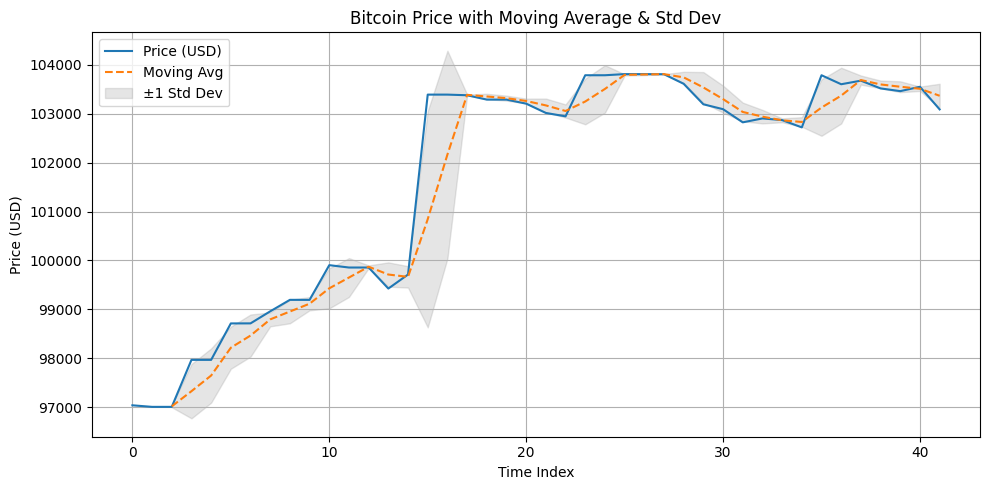

In [23]:
df = pd.read_csv("./data/bitcoin_processed.csv")

plt.figure(figsize=(10, 5))
plt.plot(df["price_usd"], label="Price (USD)")
plt.plot(df["price_ma"], label="Moving Avg", linestyle="--")
plt.fill_between(
    range(len(df)),
    df["price_ma"] - df["price_std"],
    df["price_ma"] + df["price_std"],
    alpha=0.2,
    label="±1 Std Dev",
    color="gray"
)

plt.title("Bitcoin Price with Moving Average & Std Dev")
plt.xlabel("Time Index")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Upload Processed File to AWS S3

In [24]:
bitcoin_utils.upload_to_s3("bitcoin-price-store", "processed/bitcoin_processed.csv")

INFO:bitcoin_utils:Uploading to S3...
INFO:bitcoin_utils:Uploaded to s3://bitcoin-price-store/processed/bitcoin_processed.csv


### Visualization: Time Series Analysis with Timestamps


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


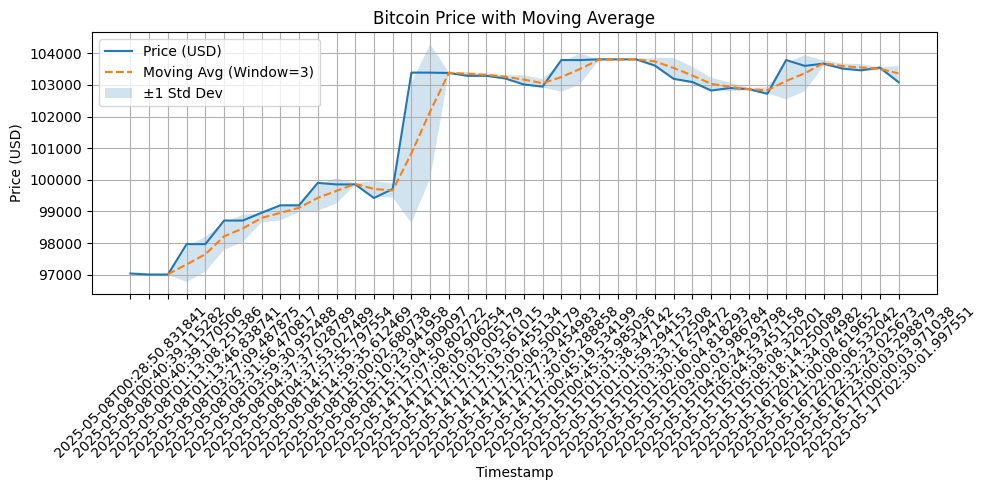

In [25]:
df = pd.read_csv("./data/bitcoin_processed.csv")

plt.figure(figsize=(10, 5))
plt.plot(df['timestamp'], df['price_usd'], label='Price (USD)')
plt.plot(df['timestamp'], df['price_ma'], label='Moving Avg (Window=3)', linestyle='--')
plt.fill_between(
    df.index,
    df['price_ma'] - df['price_std'],
    df['price_ma'] + df['price_std'],
    alpha=0.2,
    label='±1 Std Dev'
)
plt.xticks(rotation=45)
plt.title("Bitcoin Price with Moving Average")
plt.xlabel("Timestamp")
plt.ylabel("Price (USD)")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()


### Recent Trends: Latest 50 Observations


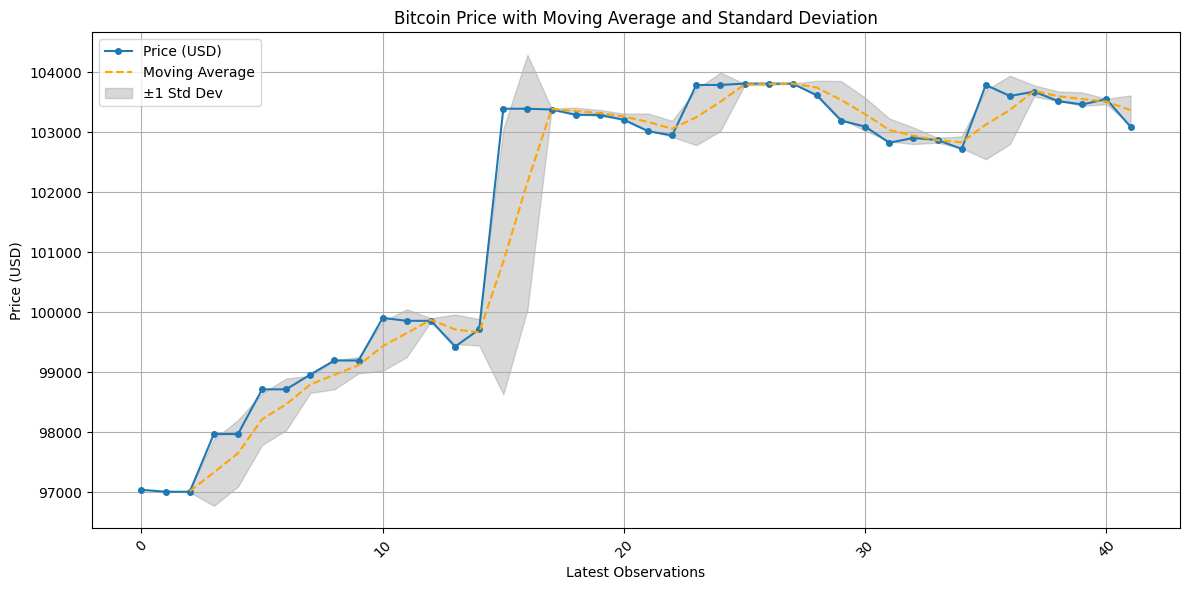

In [26]:
df = pd.read_csv("./data/bitcoin_processed.csv")
df = df.tail(50)

plt.figure(figsize=(12, 6))
plt.plot(df["price_usd"], label="Price (USD)", marker='o', markersize=4)
plt.plot(df["price_ma"], label="Moving Average", linestyle="--", color='orange')
plt.fill_between(
    range(len(df)),
    df["price_ma"] - df["price_std"],
    df["price_ma"] + df["price_std"],
    color="gray", alpha=0.3, label="±1 Std Dev"
)
plt.title("Bitcoin Price with Moving Average and Standard Deviation")
plt.xlabel("Latest Observations")
plt.ylabel("Price (USD)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Anomaly Detection Plot: 1h and 24h Price Change


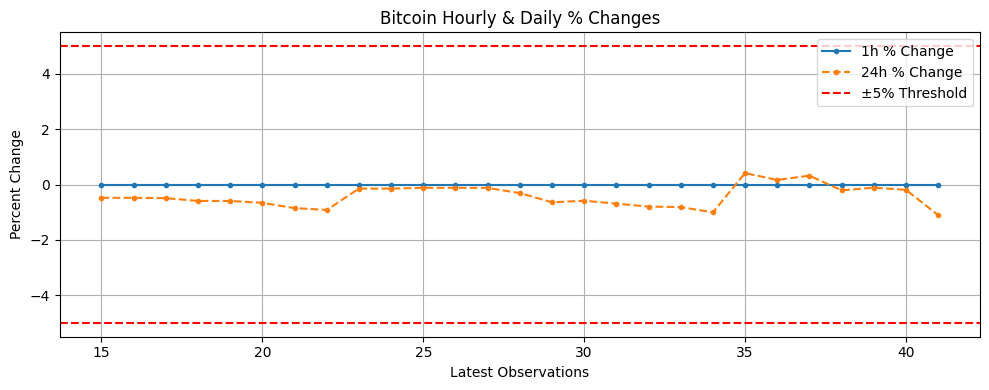

In [27]:
if "change_1h" in df.columns and "change_24h" in df.columns:
    plt.figure(figsize=(10, 4))
    plt.plot(df["change_1h"], label="1h % Change", marker='.')
    plt.plot(df["change_24h"], label="24h % Change", linestyle="--", marker='.')
    plt.axhline(y=5, color="red", linestyle="--", label="±5% Threshold")
    plt.axhline(y=-5, color="red", linestyle="--")
    plt.title("Bitcoin Hourly & Daily % Changes")
    plt.xlabel("Latest Observations")
    plt.ylabel("Percent Change")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
